In [10]:
import numpy as np
import matplotlib.pyplot as plt
from dataloader import RadarImageTargetSet
ds = RadarImageTargetSet()

In [11]:
boxes = []
for (img, tgt) in ds:
    for box in tgt['boxes']:
        boxes.append(box)
boxes = np.array(boxes)
box_xsizes = boxes[:, 2] - boxes[:, 0]
box_ysizes = boxes[:, 3] - boxes[:, 1]
max_x_size = int(max(box_xsizes))
max_y_size = int(max(box_ysizes))

print(max_x_size, max_y_size)

11 27


In [12]:
# prepare training data for DopplerNet like model

x = []
y = []
for (img, tgt) in ds:
    #print(img.shape)
    for (class_type, (y0, x0, y1, x1)) in zip(tgt['labels'], list(tgt['boxes'])):
        # cut box out of image
        #print(class_type)
        #print(x0, y0, x1, y1)
        cutout = img[int(x0):int(x1), int(y0):int(y1)]
        #print(cutout.shape)
        if cutout.shape[0] > max_x_size and cutout.shape[1] > max_y_size:
            print("can't process box of shape", x0, y0, x1, y1, cutout.shape)
            continue
        # padding putting it in upper left corner
        # TODO: center
        y_padding = int(max_y_size - cutout.shape[0])
        x_padding = int(max_x_size - cutout.shape[1])
        padded = np.pad(cutout, ((y_padding // 2, y_padding - (y_padding // 2)), (x_padding // 2, x_padding - (x_padding // 2))), mode='constant', constant_values=0.0)
        x.append(padded)
        # class as one hot encoding
        y.append([1.0 if int(class_type) == i else 0.0 for i in range(4)])

x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

(594, 27, 11)
(594, 4)


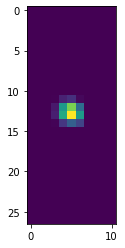

In [13]:
plt.imshow(x[30])

In [14]:
from sklearn.model_selection import train_test_split
# split
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.33, random_state=42)

x_train=np.asarray(x_train)
y_train=np.asarray(y_train)
x_test=np.asarray(x_test)
y_test=np.asarray(y_test)
x_train=np.reshape(x_train,[-1,11,27,1])
x_test=np.reshape(x_test,[-1,11,27,1])

In [16]:
import tensorflow as tf
import tensorflow.keras as k

model=k.Sequential()
model.add(tf.keras.Input(shape=(11,27,1)))
model.add(k.layers.Conv2D(32,3,3,padding='valid',
    dilation_rate=(1, 1),
    activation="relu"))
model.add(k.layers.Flatten())
model.add(k.layers.Dense(64,activation="relu"))
model.add(k.layers.Dense(64,activation="relu"))
model.add(k.layers.Dense(64,activation="relu"))
model.add(k.layers.Dense(64,activation="relu"))
model.add(k.layers.Dense(4,activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
EPOCHS = 20
history=model.fit(x_train,y_train,epochs=EPOCHS,batch_size=8)

Epoch 1/20
50/50 [==============================] - 2s 7ms/step - loss: 30.1570 - accuracy: 0.5275
Epoch 2/20
50/50 [==============================] - 0s 7ms/step - loss: 1.7036 - accuracy: 0.6695
Epoch 3/20
50/50 [==============================] - 0s 7ms/step - loss: 1.0438 - accuracy: 0.7509
Epoch 4/20
50/50 [==============================] - 0s 6ms/step - loss: 0.5678 - accuracy: 0.8228
Epoch 5/20
50/50 [==============================] - 0s 7ms/step - loss: 1.0122 - accuracy: 0.7675
Epoch 6/20
50/50 [==============================] - 0s 6ms/step - loss: 0.9044 - accuracy: 0.7437
Epoch 7/20
50/50 [==============================] - 0s 7ms/step - loss: 0.6672 - accuracy: 0.7834
Epoch 8/20
50/50 [==============================] - 0s 8ms/step - loss: 2.0408 - accuracy: 0.6710
Epoch 9/20
50/50 [==============================] - 0s 7ms/step - loss: 0.8093 - accuracy: 0.7842
Epoch 10/20
50/50 [==============================] - 0s 6ms/step - loss: 0.5443 - accuracy: 0.8259
Epoch 11/20
50/50 

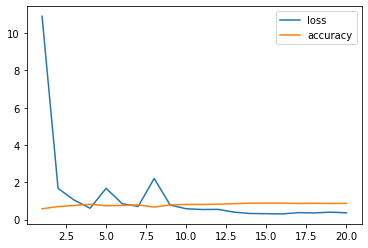

In [18]:
y_pred=history.model.predict(x_test)

plt.plot(range(1,EPOCHS+1),history.history['loss'], label='loss')

plt.plot(range(1,EPOCHS+1),history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

In [19]:
history.model.evaluate(x_test,y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.9326 - accuracy: 0.7970


[0.9325594305992126, 0.796954333782196]